In [1]:
# Import phase if every import is here it is to allow you to run this cell and know if you have any issue and not after a few hours of training

import tensorflow
from tensorflow import keras
from tensorflow.keras.layers import LeakyReLU

import os
import numpy as np
import librosa

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt


from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Activation, Flatten, MaxPooling1D, BatchNormalization, LSTM, GaussianNoise
from tensorflow.keras.models import Sequential


from src.VoiceModule import VoiceModule
from src.classifiers.KerasClassifier import KerasClassifier
from prepare_data_utils import load_wav, preprare_wav


/home/arc/fdp5/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/arc/fdp5/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/arc/fdp5/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/arc/fdp5/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.

In [2]:
# print environment
folder_path = "../../data"
for l in os.listdir(folder_path):
    print(l)

fearful
savee
calm
happy
bdes
surprised
angry
sad
keywords


In [3]:
# Transform data method

def mfcc(buffer, samplerate, dim):
    a = librosa.feature.mfcc(y=buffer, sr=samplerate, n_mfcc=dim)
    a = np.transpose(a)
    return a


In [4]:
# Create callback to later draw some graphs

class PerformanceLogger(Callback):
    def __init__(self):
        # List of tuple (loss, accuracy)
        self.training = []
        self.testing = []
    def on_epoch_end(self, epoch, logs=None):
        self.training.append((logs["loss"], logs["acc"]))
        self.testing.append((logs["val_loss"], logs["val_acc"]))

In [5]:
# This function prints metrics about a model
def print_metrics(voice_module, X, Y, label_name_list):
    Y_pred = voice_module.model._model.predict(X)
    Y_pred = np.argmax(Y_pred, axis=1)
    Y_max = np.argmax(Y, axis=1)
    print(confusion_matrix(Y_max, Y_pred))
    print(classification_report(Y_max, Y_pred, target_names=label_name_list))


In [14]:
# Create class
class EmotionClassifierLstm(KerasClassifier):
    def __init__(self, file_path=None):
        super().__init__(file_path)

    def predict(self, x):
        x = np.expand_dims(np.array([x]), axis=2)
        return self._model.predict(x)

    def build(self):
        model = Sequential()
        # This first layer add noises to the input data and serve as a data augmentation technique
        # Used to prevent overfitting of the LSTM layer and try to extract more significant feature
        model.add(GaussianNoise(0.4))
        # This layer normalise the data to speed up the training and prevent the gradient of the LSTM to explode
        # and reach exponential weight value
        model.add(BatchNormalization())
        # This is THE feature extraction layer
        model.add(LSTM(64, input_shape=(35, 13)))
        model.add(Activation('relu'))
        model.add(Flatten())
        model.add(BatchNormalization())
        # This is the second part of the network, this one will be fine tuned later
        model.add(GaussianNoise(0.2))

        # The two last layers will be fine-tuned at the end of this notebook
        model.add(Dense(32))
        model.add(Dense(5))
        model.add(Activation('softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        self._model = model
        
    def train(self, X, Y, batch_size=32, epoch=720, validation_data=None, callbacks=[]):
        self._model.fit(X, Y, batch_size=batch_size, epochs=epoch, validation_data=validation_data, callbacks=callbacks)

    def transform(self, x, samplerate):
        to_process = mfcc(x, samplerate, 13)
        to_process = pad_sequences([to_process], maxlen=35, padding='post')[0]
        return to_process


In [15]:
#Instanciate model
emotion_list = ["calm", "happy", "angry", "fearful", "sad"]
dimension_mfcc = 13
samplerate = 16000
nb_break=None
sample_duration=1
step=0.5

logger = PerformanceLogger()

cls = EmotionClassifierLstm()
vm = VoiceModule("emotion-1s", emotion_list, cls)

In [8]:
# Prepare data for training
data = {f: load_wav(f"{folder_path}/{f}", nb_break) for f in emotion_list}
X, Y = preprare_wav(data, vm, sample_duration, step)
print("Done")

Doing calm
Doing happy
Doing angry
Doing fearful
Doing sad
Done


In [9]:
X_file = f"x_{'_'.join(emotion_list)}-{vm._name}.npy"
Y_file = f"y_{'_'.join(emotion_list)}-{vm._name}.npy"

In [10]:
# Saving the prepared input data 
np.save(X_file, X)
np.save(Y_file, Y)


In [11]:
# Load data for training
X, Y = np.load(X_file), np.load(Y_file)

In [12]:
"""train_size = 80 * len(X) // 100
test_size = 20 * len(X) // 100
#X = np.expand_dims(X, axis=3)
X_train, X_test, = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]"""
X = X.astype('float32')
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(len(X_train), len(X_test))

print(X[0].shape)
print( X.dtype)

4584 1147
(35, 13)
float32


In [16]:
vm.model.train(X_train, Y_train, batch_size=64, epoch=100, validation_data=(X_test, Y_test), callbacks=[logger])

Train on 4584 samples, validate on 1147 samples
Epoch 1/100
4584/4584 [==============================] - 6s 1ms/sample - loss: 1.5032 - acc: 0.3545 - val_loss: 1.5651 - val_acc: 0.2833
Epoch 2/100
4584/4584 [==============================] - 3s 699us/sample - loss: 1.3201 - acc: 0.4370 - val_loss: 1.5130 - val_acc: 0.3086
Epoch 3/100
4584/4584 [==============================] - 5s 1ms/sample - loss: 1.2481 - acc: 0.4686 - val_loss: 1.4342 - val_acc: 0.3862
Epoch 4/100
4584/4584 [==============================] - 4s 925us/sample - loss: 1.2023 - acc: 0.4889 - val_loss: 1.3407 - val_acc: 0.4342
Epoch 5/100
4584/4584 [==============================] - 3s 695us/sample - loss: 1.1448 - acc: 0.5212 - val_loss: 1.2521 - val_acc: 0.4804
Epoch 6/100
4584/4584 [==============================] - 4s 784us/sample - loss: 1.0937 - acc: 0.5414 - val_loss: 1.2066 - val_acc: 0.4900
Epoch 7/100
4584/4584 [==============================] - 3s 632us/sample - loss: 1.0447 - acc: 0.5705 - val_loss: 1.1439 -

4584/4584 [==============================] - 4s 817us/sample - loss: 0.2503 - acc: 0.9047 - val_loss: 1.2293 - val_acc: 0.6774
Epoch 60/100
4584/4584 [==============================] - 4s 879us/sample - loss: 0.2547 - acc: 0.9071 - val_loss: 1.2058 - val_acc: 0.6870
Epoch 61/100
4584/4584 [==============================] - 4s 778us/sample - loss: 0.2545 - acc: 0.9029 - val_loss: 1.1484 - val_acc: 0.6888
Epoch 62/100
4584/4584 [==============================] - 4s 842us/sample - loss: 0.2296 - acc: 0.9116 - val_loss: 1.1970 - val_acc: 0.6800
Epoch 63/100
4584/4584 [==============================] - 5s 984us/sample - loss: 0.2458 - acc: 0.9058 - val_loss: 1.2864 - val_acc: 0.6774
Epoch 64/100
4584/4584 [==============================] - 4s 821us/sample - loss: 0.2867 - acc: 0.8949 - val_loss: 1.2258 - val_acc: 0.6861
Epoch 65/100
4584/4584 [==============================] - 4s 920us/sample - loss: 0.2186 - acc: 0.9186 - val_loss: 1.2429 - val_acc: 0.6931
Epoch 66/100
4584/4584 [=========

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_2 (GaussianNo multiple                  0         
_________________________________________________________________
batch_normalization_2 (Batch multiple                  52        
_________________________________________________________________
lstm_1 (LSTM)                multiple                  19968     
_________________________________________________________________
activation_2 (Activation)    multiple                  0         
_________________________________________________________________
flatten_1 (Flatten)          multiple                  0         
_________________________________________________________________
batch_normalization_3 (Batch multiple                  256       
_________________________________________________________________
gaussian_noise_3 (GaussianNo multiple                 

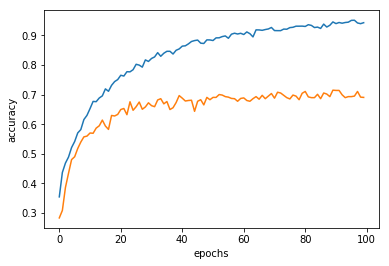

[[186  20   4  17  28]
 [ 10 157  13  24  12]
 [  6  28 158  28  13]
 [  7  24  12 151  18]
 [ 31  27  10  23 140]]
              precision    recall  f1-score   support

        calm       0.78      0.73      0.75       255
       happy       0.61      0.73      0.67       216
       angry       0.80      0.68      0.73       233
     fearful       0.62      0.71      0.66       212
         sad       0.66      0.61      0.63       231

    accuracy                           0.69      1147
   macro avg       0.70      0.69      0.69      1147
weighted avg       0.70      0.69      0.69      1147



In [17]:
vm.model._model.summary()


plt.plot(list(range(0, len(logger.training))), list(map(lambda x:x[1], logger.training)), label="training data")
plt.plot(list(range(0, len(logger.testing))), list(map(lambda x:x[1], logger.testing)), label="testing data")
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()
print_metrics(vm, X_test, Y_test, emotion_list)

In this graph we can see that the model largely overfit around the 20st epoch
We can also see that the testing data's accuracy continues to grow.

In [ ]:
# Now we save the model so we don't have to retrain it each time
vm.model.save("emotion_cnn-1s.model")

In [ ]:
# Here we load the model to check if nothing went wrong
vm.model.load("emotion_lstm-1s.model")

In [18]:
# Now we load the new dataset (savee)

# First we change the folder path
folder_path = "../../data/savee"

# Now we load the data
data = {f: load_wav(f"{folder_path}/{f}", nb_break) for f in emotion_list}
X_savee, Y_savee = preprare_wav(data, vm, sample_duration, step)
X_savee = X_savee.astype('float32')
X_savee_train, X_savee_test, Y_savee_train, Y_savee_test = train_test_split(X_savee, Y_savee, test_size=0.2, random_state=42)

Doing calm
Doing happy
Doing angry
Doing fearful
Doing sad


In [19]:
print(X_savee.shape)
vm.model._model.evaluate(X_savee, Y_savee)
print_metrics(vm, X_savee, Y_savee, emotion_list)

(1894, 35, 13)
1894/1894 [==============================] - 1s 322us/sample - loss: 6.9077 - acc: 0.2371
[[143  98  91   0  28]
 [ 82 153  71  36  26]
 [ 51 161  78  36  32]
 [ 77 119  93  29  40]
 [136 167  92   9  46]]
              precision    recall  f1-score   support

        calm       0.29      0.40      0.34       360
       happy       0.22      0.42      0.29       368
       angry       0.18      0.22      0.20       358
     fearful       0.26      0.08      0.12       358
         sad       0.27      0.10      0.15       450

    accuracy                           0.24      1894
   macro avg       0.25      0.24      0.22      1894
weighted avg       0.25      0.24      0.22      1894



In [20]:
# Now we freeze every layer used for extracting features from data
savee_model = keras.models.clone_model(vm.model._model)
for layer in savee_model.layers[:-3]:
    print(layer.name)
    layer.trainable = False
savee_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
savee_cls = EmotionClassifierLstm()
savee_cls._model = savee_model
savee_vm = VoiceModule("emotion-1s", emotion_list, savee_cls)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
gaussian_noise_2
batch_normalization_2
lstm_1
activation_2
flatten_1
batch_normalization_3
gaussian_noise_3


In [21]:
# And we train the two last layers
# This is classic fine tuning
savee_vm.model.train(X_savee_train, Y_savee_train, batch_size=10, validation_data=(X_savee_test, Y_savee_test), epoch=100)

Train on 1515 samples, validate on 379 samples
Epoch 1/100
1515/1515 [==============================] - 3s 2ms/sample - loss: 1.6418 - acc: 0.2686 - val_loss: 1.6205 - val_acc: 0.1557
Epoch 2/100
1515/1515 [==============================] - 2s 1ms/sample - loss: 1.4276 - acc: 0.3690 - val_loss: 1.6150 - val_acc: 0.1953
Epoch 3/100
1515/1515 [==============================] - 2s 2ms/sample - loss: 1.3784 - acc: 0.4007 - val_loss: 1.6157 - val_acc: 0.1715
Epoch 4/100
1515/1515 [==============================] - 3s 2ms/sample - loss: 1.3581 - acc: 0.3802 - val_loss: 1.6152 - val_acc: 0.2005
Epoch 5/100
1515/1515 [==============================] - 2s 2ms/sample - loss: 1.3568 - acc: 0.3947 - val_loss: 1.6163 - val_acc: 0.1689
Epoch 6/100
1515/1515 [==============================] - 2s 2ms/sample - loss: 1.3489 - acc: 0.4013 - val_loss: 1.6167 - val_acc: 0.1741
Epoch 7/100
1515/1515 [==============================] - 3s 2ms/sample - loss: 1.3433 - acc: 0.4119 - val_loss: 1.6145 - val_acc: 0

1515/1515 [==============================] - 3s 2ms/sample - loss: 1.3188 - acc: 0.4152 - val_loss: 1.6356 - val_acc: 0.1794
Epoch 61/100
1515/1515 [==============================] - 3s 2ms/sample - loss: 1.3031 - acc: 0.4158 - val_loss: 1.6349 - val_acc: 0.1636
Epoch 62/100
1515/1515 [==============================] - 3s 2ms/sample - loss: 1.2965 - acc: 0.4482 - val_loss: 1.6306 - val_acc: 0.1900
Epoch 63/100
1515/1515 [==============================] - 3s 2ms/sample - loss: 1.3202 - acc: 0.4257 - val_loss: 1.6286 - val_acc: 0.1609
Epoch 64/100
1515/1515 [==============================] - 3s 2ms/sample - loss: 1.3108 - acc: 0.4211 - val_loss: 1.6258 - val_acc: 0.1873
Epoch 65/100
1515/1515 [==============================] - 2s 2ms/sample - loss: 1.2940 - acc: 0.4330 - val_loss: 1.6296 - val_acc: 0.1741
Epoch 66/100
1515/1515 [==============================] - 2s 2ms/sample - loss: 1.3258 - acc: 0.4119 - val_loss: 1.6340 - val_acc: 0.1662
Epoch 67/100
1515/1515 [=======================

In [22]:
print_metrics(savee_vm, X_savee_test, Y_savee_test, emotion_list)

[[ 0  0 26  9 37]
 [ 0  0 20  9 49]
 [ 0  0 16  7 42]
 [ 0  0 21 18 33]
 [ 0  0 34 11 47]]
              precision    recall  f1-score   support

        calm       0.00      0.00      0.00        72
       happy       0.00      0.00      0.00        78
       angry       0.14      0.25      0.18        65
     fearful       0.33      0.25      0.29        72
         sad       0.23      0.51      0.31        92

    accuracy                           0.21       379
   macro avg       0.14      0.20      0.15       379
weighted avg       0.14      0.21      0.16       379



/home/arc/fdp5/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
# Now we load the new dataset (savee)

# First we change the folder path
folder_path = "../../data/bdes"

# Now we load the data
data = {f: load_wav(f"{folder_path}/{f}", nb_break) for f in emotion_list}
X_bdes, Y_bdes = preprare_wav(data, vm, sample_duration, step)
X_bdes = X_bdes.astype('float32')
X_bdes_train, X_bdes_test, Y_bdes_train, Y_bdes_test = train_test_split(X_bdes, Y_bdes, test_size=0.2, random_state=42)

Doing calm
Doing happy
Doing angry
Doing fearful
Doing sad


In [29]:
print(X_bdes.shape)
vm.model._model.evaluate(X_bdes, Y_bdes)
print_metrics(vm, X_bdes, Y_bdes, emotion_list)

(1448, 35, 13)
1448/1448 [==============================] - 1s 791us/sample - loss: 7.1129 - acc: 0.2403
[[  7  57 125  69   0]
 [  0  80  85  92   0]
 [  3  97 149  70   1]
 [  0  33  63 112   0]
 [ 28 128  76 173   0]]
              precision    recall  f1-score   support

        calm       0.18      0.03      0.05       258
       happy       0.20      0.31      0.25       257
       angry       0.30      0.47      0.36       320
     fearful       0.22      0.54      0.31       208
         sad       0.00      0.00      0.00       405

    accuracy                           0.24      1448
   macro avg       0.18      0.27      0.19      1448
weighted avg       0.17      0.24      0.18      1448



In [30]:
# Now we freeze every layer used for extracting features from data
bdes_model = keras.models.clone_model(vm.model._model)
for layer in bdes_model.layers[:-3]:
    print(layer.name)
    layer.trainable = False
bdes_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
bdes_cls = EmotionClassifierLstm()
bdes_cls._model = bdes_model
bdes_vm = VoiceModule("emotion-1s", emotion_list, bdes_cls)

gaussian_noise_2
batch_normalization_2
lstm_1
activation_2
flatten_1
batch_normalization_3
gaussian_noise_3


In [31]:
# And we train the two last layers
# This is classic fine tuning
bdes_vm.model.train(X_bdes_train, Y_bdes_train, batch_size=10, validation_data=(X_bdes_test, Y_bdes_test), epoch=100)

Train on 1158 samples, validate on 290 samples
Epoch 1/100
1158/1158 [==============================] - 5s 4ms/sample - loss: 1.4354 - acc: 0.4076 - val_loss: 1.6884 - val_acc: 0.1966
Epoch 2/100
1158/1158 [==============================] - 3s 3ms/sample - loss: 1.1632 - acc: 0.5181 - val_loss: 1.6910 - val_acc: 0.2000
Epoch 3/100
1158/1158 [==============================] - 3s 3ms/sample - loss: 1.1127 - acc: 0.5225 - val_loss: 1.6869 - val_acc: 0.1931
Epoch 4/100
1158/1158 [==============================] - 3s 3ms/sample - loss: 1.0649 - acc: 0.5535 - val_loss: 1.6817 - val_acc: 0.2000
Epoch 5/100
1158/1158 [==============================] - 3s 3ms/sample - loss: 1.0460 - acc: 0.5423 - val_loss: 1.6787 - val_acc: 0.2138
Epoch 6/100
1158/1158 [==============================] - 3s 3ms/sample - loss: 1.0454 - acc: 0.5648 - val_loss: 1.6749 - val_acc: 0.2034
Epoch 7/100
1158/1158 [==============================] - 3s 3ms/sample - loss: 1.0140 - acc: 0.5674 - val_loss: 1.6598 - val_acc: 0

1158/1158 [==============================] - 3s 3ms/sample - loss: 0.9877 - acc: 0.5803 - val_loss: 1.7392 - val_acc: 0.2517
Epoch 61/100
1158/1158 [==============================] - 4s 3ms/sample - loss: 1.0251 - acc: 0.5708 - val_loss: 1.7289 - val_acc: 0.2517
Epoch 62/100
1158/1158 [==============================] - 4s 3ms/sample - loss: 0.9919 - acc: 0.5786 - val_loss: 1.7301 - val_acc: 0.2448
Epoch 63/100
1158/1158 [==============================] - 3s 3ms/sample - loss: 0.9434 - acc: 0.5941 - val_loss: 1.7305 - val_acc: 0.2586
Epoch 64/100
1158/1158 [==============================] - 4s 3ms/sample - loss: 0.9892 - acc: 0.5682 - val_loss: 1.7400 - val_acc: 0.2483
Epoch 65/100
1158/1158 [==============================] - 3s 3ms/sample - loss: 0.9574 - acc: 0.5838 - val_loss: 1.7394 - val_acc: 0.2586
Epoch 66/100
1158/1158 [==============================] - 3s 3ms/sample - loss: 0.9631 - acc: 0.5984 - val_loss: 1.7376 - val_acc: 0.2414
Epoch 67/100
1158/1158 [=======================

In [32]:
print_metrics(bdes_vm, X_bdes_test, Y_bdes_test, emotion_list)

[[35  5  6  0  0]
 [18  4 30  0  0]
 [17 10 33  0  0]
 [27  6 18  0  0]
 [64  5 12  0  0]]
              precision    recall  f1-score   support

        calm       0.22      0.76      0.34        46
       happy       0.13      0.08      0.10        52
       angry       0.33      0.55      0.42        60
     fearful       0.00      0.00      0.00        51
         sad       0.00      0.00      0.00        81

    accuracy                           0.25       290
   macro avg       0.14      0.28      0.17       290
weighted avg       0.13      0.25      0.16       290



/home/arc/fdp5/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
